In [1]:
from numpy.random import normal,multivariate_normal
import numpy as np
from numpy.linalg import inv
from numpy import genfromtxt

from scipy import *
from scipy.linalg import norm, pinv, det
from scipy.optimize import minimize


import cvxopt as opt
from cvxopt import matrix, solvers


import matplotlib.pyplot as plt
#import numdifftools as nd

from PIL import Image
import matplotlib.image as mping

import pandas as pd
from __future__ import division


In [2]:
#Read the data 
Xtr = genfromtxt('Xtr.csv', delimiter = ',')
d = Xtr.shape[1]

Xtr = np.delete(Xtr, (d-1), axis = 1)

Ytr = pd.read_csv('Ytr.csv')
Ytr = np.array(Ytr)
Ytr = np.delete(Ytr, (0), axis = 1)

n = Xtr.shape[0]
d = Xtr.shape[1]

#Xtr is a 5000 * 3072 dimensional matrix

#Ytr is a 5000*1 dimensional matrix


[ 0.00701831  0.00032327  0.00221461 ...,  0.00522321 -0.0008604
 -0.01288091]


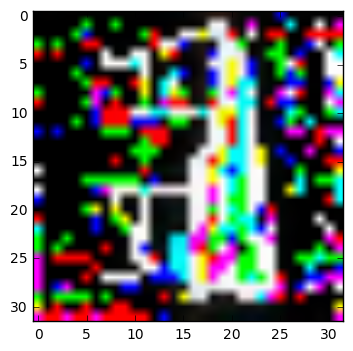

In [69]:
#The block to display images

def displayImage(image):
    plt.imshow(image)
    plt.show()

Im = Xtr[0]

Im = np.reshape(Im,(3,32,32))
Im = Im.T
displayImage(Im)

In [82]:
#Preprocessing images
#Code to tranform images into 16*16*16 dimensional histograms

#This function enforces the number C to be equal to 16 if C is greater than 16
def maxInt(NbBins, C):
    if C > NbBins-1:
        return NbBins-1
    else:
        return C


#Here we quantize the image

def quantize(Image):
    
    #Image is a 3*1024 dimensional matrix
    
    Rmax = amax(Image[0,:])
    Rmin = amin(Image[0,:])
    
    Gmax = amax(Image[1,:])
    Gmin = amin(Image[1,:])

    Bmax = amax(Image[2,:])
    Bmin = amin(Image[2,:])
    
    #Range of all chanel RGB
    Rrange = Rmax-Rmin
    Grange = Gmax-Gmin
    Brange = Bmax-Bmin
    
    #We want 16 intervals for each colour
    qR = float(Rrange)/16
    qG = float(Grange)/16
    qB = float(Brange)/16
    
    
    I= np.zeros((3,1024))
    histogram = np.zeros((16,16,16))
    #I= np.zeros((32,32,3))
    for pixel in range(1024):
            #r,g, and b respectively represent the bin number to which pixel belongs
            r = ceil(float(Im[0,pixel]-Rmin)/qR)
            g = ceil(float(Im[1,pixel]-Gmin)/qG)
            b = ceil(float(Im[2,pixel]-Bmin)/qB)
            
            #We assign new value for the new image I
            I[0,pixel] = r*qR + float(qR)/2 + Rmin
            I[1,pixel] = g*qG + float(qG)/2 + Gmin
            I[2,pixel] = b*qB + float(qB)/2 + Bmin
            
            #I[i,j,0] = ceil(float(Im[i,j,0]-Rmin)/qR)*qR + float(qR)/2 + Rmin
            #I[i,j,1] = ceil(float(Im[i,j,1]-Gmin)/qG)*qG + float(qG)/2 + Gmin
            #I[i,j,2] = ceil(float(Im[i,j,2]-Bmin)/qB)*qB + float(qB)/2 + Bmin
            
            #The histogram is updated by adding 1 to the new corresponding bin
            histogram[maxInt(16,r), 
                      maxInt(16,g), 
                      maxInt(16,b)]+=1
            
            
    return I,histogram

In [84]:
#In this block we fill the new images (encoded with 16 bins) and the histograms

X = np.zeros(Xtr.shape)

#Histograms is a 5000 * 16 * 16 * 16 dimensional matrix

Histograms = np.zeros((Xtr.shape[0], 16,16,16))

for i in range(Xtr.shape[0]):
    Im = Xtr[i]
    Im = np.reshape(Im,(3,1024))
    I, histogram = quantize(Im)
    X[i,:] = np.concatenate([I[0,:], I[1,:], I[2,:]])
    Histograms[i,:,:,:] = histogram 


C:\Users\abc\Anaconda2\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [61]:
rho = 1

#The distance chi2 is a distance between two histograms defines as the sum over all bins
def distance_histograms_chi2(histo1, histo2):
    value = 0
    d = histo1.shape[0]
    for i in range(d):
        for j in range(d):
            for k in range(d):
                if(histo1[i,j,k] + histo2[i,j,k] != 0):
                    value += ((histo1[i,j,k] - histo2[i,j,k])**2/(histo1[i,j,k] + histo2[i,j,k]))
    return value


#The RBF kernel suggested in the article use the gaussian kernel replacing the usual norm by the distance chi2
def RBF_Kernel(histo1, histo2):
    return exp((-rho)*distance_histograms_chi2(histo1,histo2))

In [74]:
#I mmodified a bit th linear kernel to test the efficiency of a polynomial kernel. 
#Clearly we should better use a polynomial kernel with a degree greater or equal than 2
def Linear_Kernel(x,y):
    return (np.dot(x,y))**2

def Gaussian_Kernel(x,y, sigma):
    return exp((-1/2)*np.dot(x-y,x-y)/float(2*sigma))


#Return x (images) and y corresponding to label1 and label2 
def Fill_x_y_label(label1,label2):
    
    x1=X[np.where(Ytr==label1)[0],:]
    x2=X[np.where(Ytr==label2)[0],:]
    x=np.concatenate([x1,x2])
    
    
    y1=np.ones(x1.shape[0])
    y2=-1*np.ones(x2.shape[0])
    y=np.concatenate([y1,y2])
    return x,y;

#Return histograms and y corresponding to label1 and label2 
def Fill_histo_y_label(label1,label2):
    
    histo1=Histograms[np.where(Ytr==label1)[0],:,:,:]
    histo2=Histograms[np.where(Ytr==label2)[0],:,:,:]
    histo=np.concatenate([histo1,histo2], axis = 0)
    
    
    y1=np.ones(histo1.shape[0])
    y2=-1*np.ones(histo2.shape[0])
    y=np.concatenate([y1,y2])
    return histo,y;

#Definition of the jacobian matrix(gradient)
def SVM_dual_function_Jac(alpha):
    return -(2*y - 2*np.dot(K,alpha))

#Definition of the Hessian matrix
def SVM_dual_function_Hess(alpha):
    return K

In [54]:
#Cross-validation procedure

#NbTrain is a number of training data labeled by 1 I extract from the initial dataset
#NbTrain =400 in our case. I consider 400 data points of label 1 in tmy training set

def Fill_Training_Set(x, y, NbTrain):
    N = 2 * NbTrain
    NbTest = x.shape[0] - N
    
    yTrain = np.concatenate([y[0:NbTrain],y[500: 500 + NbTrain]])
    xTrain = np.concatenate([x[0:NbTrain,:],x[500: 500 + NbTrain,:]])
    
    KTrain=np.zeros((N,N))
    for line in range(N):
        for col in range(N):
            if (line<=col):
                value= Linear_Kernel(xTrain[line,:],xTrain[col,:])
                KTrain[col,line]=value
                KTrain[line,col]=value
    return xTrain,yTrain,KTrain


#Exactly the same with histograms
def Fill_Trainin_histo(histogramSet, y, NbTrain):
    N = 2 * NbTrain
    NbTest = histogramSet.shape[0] - N
    
    yTrain = np.concatenate([y[0:NbTrain],y[500: 500 + NbTrain]])
    histoTrain = np.concatenate([histogramSet[0:NbTrain,:,:,:],histogramSet[500: 500 + NbTrain,:,:,:]])
    
    KTrain=np.zeros((N,N))
    for line in range(N):
        print line
        for col in range(N):
            if (line<=col):
                value= RBF_Kernel(histogramSet[line,:,:,:],histogramSet[col,:,:,:])
                KTrain[col,line]=value
                KTrain[line,col]=value
    return histoTrain,yTrain,KTrain

#Fill the test histograms
#histoTest is a 200 * 16 *16*16 dimensional matrix
def Fill_Test_Histo(histogramSet, y, NbTrain):
    yTest = np.concatenate([y[NbTrain:500],y[500 + NbTrain:1000]])
    histoTest = np.concatenate([histogramSet[NbTrain:500,:,:,:],histogramSet[500 + NbTrain:1000,:,:,:]], axis =0)
    
    return histoTest, yTest


def Fill_Test_Set(x,y,NbTrain):
    yTest = np.concatenate([y[NbTrain:500],y[500 + NbTrain:1000]])
    xTest = np.concatenate([x[NbTrain:500,:],x[500 + NbTrain:1000,:]])
    
    return xTest, yTest


#Optimization model
def Training_model(y, K, Lambda):
    P = matrix(2*K)
    q = matrix(-2*y)
    G = matrix(np.concatenate(((-1)*np.diag(y),np.diag(y))), tc='d')
    h = matrix(np.concatenate([np.zeros(y.shape), (1/(2*float(Lambda*y.shape[0])))*np.ones(y.shape)]), tc='d')
    A = matrix(np.ones(y.shape), (1, y.shape[0]))
    b = matrix(1.0)
    sol = solvers.qp(P,q,G,h)
    alpha = sol['x']
    print sol['status']
    alpha = np.array(alpha)
    return alpha

#Compute the new obtained label
def SVM_function(alpha, xtrain ,x_querry):
    value = 0
    for i in range(alpha.shape[0]):
        Current_Image=xtrain[i,:]
        value += alpha[i]*Linear_Kernel(x_querry,Current_Image)
    return np.sign(value)

def SVM_function_histo(alpha, histoTrain ,histo_querry):
    value = 0
    for i in range(alpha.shape[0]):
        Current_Image=histoTrain[i,:,:,:]
        value += alpha[i]*RBF_Kernel(histo_querry,Current_Image)
    return np.sign(value)

In [19]:
#Just a test for the one vs one classifier
NbTrain = 400
Lambda=0.0001

histo,y = Fill_histo_y_label(1,2)

#Get the training set, it takes too much time !!!
histoTrain, yTrain,KTrain = Fill_Trainin_histo(histo, y, NbTrain)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [52]:
Lambda=0.0001
alpha  = Training_model(yTrain, KTrain, Lambda)

NbTest = 2*(500-NbTrain)

#Get the test set
histoTest, yTest = Fill_Test_Histo(histo, y, NbTrain)

error = 0
for i in (np.arange(0, 100)):
    Label_found = SVM_function_histo(alpha, histoTrain, histoTest[i,:])
    if(Label_found != yTest[i]):
        error += 1
    Accuracy = (1-(error)/(i+1))*100.0
    print 'Accuracy :', Accuracy, '%'

        

     pcost       dcost       gap    pres   dres
 0: -1.1686e+03 -1.8873e+04  2e+04  3e-17  8e-14
 1: -1.4885e+03 -3.7429e+03  2e+03  1e-16  9e-14
 2: -1.5762e+03 -1.8519e+03  3e+02  2e-16  9e-14
 3: -1.5853e+03 -1.6038e+03  2e+01  2e-16  9e-14
 4: -1.5862e+03 -1.5870e+03  8e-01  2e-16  8e-14
 5: -1.5863e+03 -1.5864e+03  3e-02  2e-16  9e-14
 6: -1.5863e+03 -1.5863e+03  1e-03  2e-16  9e-14
Optimal solution found.
optimal
[-8.31198909]
Accuracy : 100.0 %
[ 8.48467865]
Accuracy : 50.0 %
[ 1.43448297]
Accuracy : 33.3333333333 %
[ 10.03292663]
Accuracy : 25.0 %
[ 5.86214479]
Accuracy : 20.0 %
[ 14.3475529]
Accuracy : 16.6666666667 %
[ 9.48637709]
Accuracy : 14.2857142857 %
[ 5.75879122]
Accuracy : 12.5 %
[-0.7274293]
Accuracy : 22.2222222222 %
[ 0.1002943]
Accuracy : 20.0 %
[ 6.37483027]
Accuracy : 18.1818181818 %
[ 10.98086978]
Accuracy : 16.6666666667 %
[ 2.75558648]
Accuracy : 15.3846153846 %
[ 9.14645899]
Accuracy : 14.2857142857 %
[ 2.68620053]
Accuracy : 13.3333333333 %
[ 4.91419786]
A

KeyboardInterrupt: 

In [57]:
#Block to perform the optimization with the linear kernel

#Just a test for the one vs one classifier
NbTrain = 400
Lambda=0.0001

x,y = Fill_x_y_label(1,2)
xTrain, yTrain,KTrain = Fill_Training_Set(x, y, NbTrain)
xTest, yTest = Fill_Test_Set(x, y, NbTrain)
alpha  = Training_model(yTrain, KTrain, Lambda)


NbTest = 2*(500-NbTrain)

error = 0
for i in range(NbTest):
    Label_found = SVM_function(alpha, xTrain, xTest[i,:])
    if(Label_found != yTest[i]):
        error += 1
    

Accuracy = (1-(float(error)/NbTest))*100.0
    
print 'Accuracy :', Accuracy, '%'

     pcost       dcost       gap    pres   dres
 0:  2.5241e+08 -1.0931e+09  2e+09  1e-02  2e-11
 1:  6.1270e+07 -8.6963e+07  2e+08  2e-04  2e-11
 2:  8.9537e+06 -9.7490e+06  2e+07  2e-16  9e-12
 3:  1.2809e+06 -1.4281e+06  3e+06  2e-16  4e-12
 4:  1.8217e+05 -2.0522e+05  4e+05  2e-16  1e-12
 5:  2.5560e+04 -2.9939e+04  6e+04  2e-16  5e-13
 6:  3.4462e+03 -4.5011e+03  8e+03  2e-16  2e-13
 7:  4.0252e+02 -7.3172e+02  1e+03  2e-16  8e-14
 8:  1.3047e+01 -1.4500e+02  2e+02  2e-16  3e-14
 9: -2.6695e+01 -4.5381e+01  2e+01  2e-16  1e-14
10: -2.8701e+01 -2.9753e+01  1e+00  2e-16  9e-15
11: -2.8757e+01 -2.8796e+01  4e-02  2e-16  8e-15
12: -2.8763e+01 -2.8764e+01  1e-03  2e-16  8e-15
13: -2.8763e+01 -2.8763e+01  6e-05  2e-16  7e-15
14: -2.8763e+01 -2.8763e+01  4e-06  2e-16  8e-15
Optimal solution found.
optimal
Accuracy : 70.0 %


In [ ]:
#Number of observation from k-th class in training set 
NbTrain = 400
N = 2*NbTrain
NbLabel = 10


AlphaClassifiers = np.zeros((NbLabel,NbLabel,N))


for label1 in range(NbLabel): 
    for label2 in range(NbLabel):
        if(label2 > label1):
            x,y = Fill_x_y_label(label1,label2)
            xTrain, yTrain,KTrain = Fill_Training_Set(x, y, NbTrain)
            alpha  = Training_model(yTrain, KTrain, Lambda)
            AlphaClassifiers[label1, label2, :] = alpha[:,0]
        


In [ ]:
xtest =np.zeros((1,3072))
ytest = np.zeros((1,1))
xtrain = np.zeros((NbLabel,NbTrain,3072))

for label in range(NbLabel):
    x1=Xtr[np.where(Ytr==label)[0],:]
    xtrain[label,:,:] = x1[0: NbTrain,:]
    xtest=np.concatenate([xtest,x1[NbTrain: 500,:]])
    
    y1 = label * np.ones((500 - NbTrain, 1))
    ytest=np.concatenate([ytest,y1])


xtest = np.delete(xtest, 0, 0)
ytest = np.delete(ytest, 0, 0)


    
def FindLabels(TestSet):
    delta = np.zeros((NbLabel,TestSet.shape[0]))
    for label1 in range(NbLabel):
        print label1
        for label2 in range(NbLabel):
            if(label2 > label1):
                current_training_set = np.concatenate([xtrain[label1,:,:],xtrain[label2,:,:]])
                for i in range(TestSet.shape[0]):
                    value = SVM_function(AlphaClassifiers[label1,label2,:], current_training_set, TestSet[i,:])
                    if value > 0:
                        delta[label1,i] += 1
                    if value < 0:
                        delta[label2,i] += 1
    return delta

NbTest = NbLabel*(500-NbTrain)
error =0

delta=FindLabels(xtest)
for i in range(NbTest):
    label_found = amax(delta[:,i])
    if(label_found != ytest[i]):
        error = error +1
        
        
Accuracy = (1-(float(error)/NbTest))*100.0
    
print 'Accuracy :', Accuracy, '%'

                
            

In [134]:
# See tutorial at http://scikit-learn.org/stable/modules/svm.html#svm-regression


from sklearn import svm
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.utils import column_or_1d
X=np.array(Xtr)
Y=np.array(Ytr)
[x,y]= Fill_x_y_label(1,2)

#classif = OneVsRestClassifier(SVC(kernel=Polynomial_Kernel))

#y = column_or_1d(y, warn=True)

#N=y.shape[0]
#KTrain=np.zeros((N,N))
#for line in range(N):       
    #for col in range(N):
        #if (line<=col):
            #value= Polynomial_Kernel(x[col,:],x[line,:])
            #KTrain[col,line]=value
            #KTrain[line,col]=value
#clf = svm.SVC(kernel='precomputed')
#classif = OneVsRestClassifier(SVC(kernel='linear'))
#clf.fit(KTrain,y)

#scores = cross_val_score(clf, KTrain, y, cv=5)


In [150]:
def Polynomial_Kernel(x,y,coeff):
    sum=0;
    product=(np.dot(x,y));
    for power in range(len(coeff)):
        sum=sum+coeff[power]*product**(power+1)
    return sum

def value_fonction(p):
   
    N=y.shape[0]
    G=np.zeros((N,N))
    for line in range(N):       
        for col in range(N):
            if (line<=col):
                value= Polynomial_Kernel(x[col,:],x[line,:],p)
                G[col,line]=value
                G[line,col]=value
    clf = svm.SVC(kernel='precomputed')
    print 
    value=max(cross_val_score(clf, G, y, cv=2 ))
    print(value)
    return - value

def find_optimal_parameters_on_data(x,y,max_degree):
    var_par=np.zeros(max_degree)
    res= minimize(value_fonction, var_par, tol=1e-3,options={'disp': True, 'maxiter':10,'eps' : 0.3})
    return res

In [ ]:
r=find_optimal_parameters_on_data(x,y,4)

[ 0.  0.  0.]
0.5
[ 0.3  0.   0. ]
0.67
[ 0.   0.3  0. ]
0.55
[ 0.   0.   0.3]
0.5
[ 0.  0.  0.]
0.5
[ 0.56666667  0.16666667  0.        ]
0.686
[ 0.56666667  0.16666667  0.        ]
0.686
[ 0.86666667  0.16666667  0.        ]
0.69
[ 0.56666667  0.46666667  0.        ]
0.676
[ 0.56666667  0.16666667  0.3       ]
0.524
[ 1.06127056  0.2746687  -0.54311339]
0.682
[ 1.06127056  0.2746687  -0.54311339]
0.682
[ 1.36127056  0.2746687  -0.54311339]
0.706
[ 1.06127056  0.5746687  -0.54311339]
0.714
[ 1.06127056  0.2746687  -0.24311339]
0.694
[ 0.71956385  0.2000534  -0.16789295]
0.69
[ 0.71956385  0.2000534  -0.16789295]
0.69
[ 1.01956385  0.2000534  -0.16789295]
0.692
[ 0.71956385  0.5000534  -0.16789295]
0.706
[ 0.71956385  0.2000534   0.13210705]
0.578
[ 0.73649323  0.21295932 -0.18738979]
0.714
[ 0.73649323  0.21295932 -0.18738979]
0.714
[ 1.03649323  0.21295932 -0.18738979]
0.674
[ 0.73649323  0.51295932 -0.18738979]
0.71
[ 0.73649323  0.21295932  0.11261021]
0.594
[ 0.74210556  0.2707430

In [ ]:
print(r)

(1000,)


9
3
7


87
